# Topic1. Grid Problem and Path Search

If you got the point for problem definition in AIMA textbook, please run the block directly until section 1-3. The section 1-1 to 1-2 is the same as tutorial last week. 

## 1-1. Import python package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
import numpy as np
from collections import defaultdict, deque, Counter
from itertools import combinations

## 1-2. Problem abstract & State-space tree node & queue

In [2]:
class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    Subclasses can add other keywords besides initial and goal.
    The default heuristic is 0 and the default step cost is 1 for all states."""

    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds) 
    
    
    def actions(self, state):           raise NotImplementedError
    def result(self, state, action):    raise NotImplementedError
    def is_goal(self, state):           return state == self.goal
    def step_cost(self, s, action, s1): return 1
    def h(self, node):                  return 0
    
    def __str__(self):
        return '{}({}, {})'.format(type(self).__name__, self.initial, self.goal)
    

class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost
    
    
failure = Node('failure', path_cost=float('inf')) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=float('inf')) # Indicates iterative deepening search was cut off.
    
    
def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.step_cost(s, action, s1)
        yield Node(s1, node, action, cost)
        

def path_actions(node):
    "The sequence of actions to get to this node."
    return [] if node.parent is None else path_actions(node.parent) + [node.action]


def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None): return []
    return path_states(node.parent) + [node.state]

<font color="red">
    
## 1-3. Grid Problem

</font>

We define a `GridProblem` class here to present a problem has an initial point, a goal point, obstacles and other limitations. Assume a robot is locate on initial point, you need to use search method to plan a path and avoid robot bump into the wall.

In [3]:
class GridProblem(Problem):
    """Finding a path on a 2D grid with obstacles. Obstacles are (x, y) cells."""
    
    def __init__(self, initial=(0.5, 0.5), goal=(1.5, 2.5), obstacles=(),
                 grid_size=0.2, veh_size=(0.2, 0.2), MAP_RANGE=(150, 60), **kwds):
        Problem.__init__(self, initial=initial, goal=goal, obstacles=set(obstacles) - {initial, goal},
                         grid_size=grid_size, veh_size=veh_size, MAP_RANGE=MAP_RANGE, **kwds)
        
        # Safety check for goal point setting
        if not self.is_state_safe(self.goal):
            raise ValueError('Initial point:{} or goal:{} is out of range {}~{} m'.format( \
                                self.initial, self.goal, self.veh_size, \
                                (self.MAP_RANGE[0]-self.veh_size[0], self.MAP_RANGE[1]-self.veh_size[1])))
        
        # Define the directions that robot can move to
        self.directions = [(0, -1), (-1, 0), (1,  0), (0, +1)]
        
        # Define an empty set for grid map, the concept is the same as sparse matrix
        self.gridmap = set()
        
        # Method for converting real map location to a grid map, there is a tricky problem 
        self.to_grid = lambda state: (int(state[0]*10/self.grid_size/10), int(state[1]*10/self.grid_size/10))
        
        self.generate_gridmap()   
        
        
    def is_state_safe(self, state):
        if state[0] < self.veh_size[0] or state[0] > self.MAP_RANGE[0]-self.veh_size[0] or \
            state[1] < self.veh_size[1] or state[1] > self.MAP_RANGE[1]-self.veh_size[1]:
            return False
        else:    return True
    
    
    def generate_gridmap(self):
        for p in self.obstacles:
            self.gridmap.add(self.to_grid(p))
        
        # Remove initial point and goal point from grid map
        self.gridmap = self.gridmap - {self.to_grid(self.initial), self.to_grid(self.goal)}
            
                
    def result(self, state, action): 
        "Both states and actions are represented by (x, y) pairs."
        result_grid_loc = self.to_grid(state)
        return action if action not in self.gridmap else state
    
    
    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell."""
        x, y = state
        grid_p = self.to_grid(state)
        action_list = []
        for (dx, dy) in self.directions:
            next_p = (grid_p[0]+dx, grid_p[1]+dy)
            if next_p not in self.gridmap:
                action_list.append((round(next_p[0]*self.grid_size + 0.5*self.grid_size, 3), \
                                    round(next_p[1]*self.grid_size + 0.5*self.grid_size, 3)))
        return action_list
    
    
    def is_goal(self, state):
        return self.to_grid(state) == self.to_grid(self.goal)

    
    def step_cost(self, s, action, s1): return straight_line_distance(s, s1)
    
    
    def h(self, node): return straight_line_distance(node.state, self.goal)
                  

## 1-4. Obstacle generator

This section is prepared for obstacle generator. Note that we use `yield` to create iterable variable, then use `set()` to include all elements in the grid problem. If you want to know more about `yield`, please ask TA or visit [Stackflew](https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do) or [Chinese intro](https://liam.page/2017/06/30/understanding-yield-in-python/).

In [4]:
def transpose(matrix): return list(zip(*matrix))


# The following can be used to create obstacles:
def straight_line_distance(point1, point2):
    "Straight-line distance between two 2D points."
    return abs(complex(*point1) - complex(*point2))
    

def random_lines(X=np.arange(0, 150, 0.1), Y=np.arange(10, 70, 0.1), N=100, lengths=np.arange(6, 12, 0.1), dirs=((0, 1), (1, 0))):
    """Yield the cells in N random lines of the given lengths."""
    for obj_line in add_block(x=0, y=0, len_x=150, len_y=80):
        yield obj_line
        
    for obj_line in add_block(x=0, y=0, len_x=1.6, len_y=2.8):
        yield obj_line
    
    for _ in range(N):
        x, y = random.choice(X), random.choice(Y)
        dx, dy = random.choice(dirs)
        for obj_line in line(x, y, dx, dy, random.choice(lengths)):
            yield obj_line            

def random_blocks(X=np.arange(0, 150, 0.1), Y=np.arange(10, 70, 0.1), N=40, lengths=np.arange(4, 8, 0.1), dirs=((0, 1), (1, 0))):
    """A line of `length` cells starting at (x, y) and going in (dx, dy) direction."""
    for obj_line in add_block(x=0, y=0, len_x=150, len_y=80):
        yield obj_line
    
    for _ in range(N):
        x1, y1 = random.choice(X), random.choice(Y)
        dx, dy = random.choice(lengths), random.choice(lengths)
        
        for obj_line in line(x1, y1, 1, 0, dx+1):
            yield obj_line
        for obj_line in line(x1, y1+dy, 1, 0, dx+1):
            yield obj_line
        for obj_line in line(x1, y1, 0, 1, dy):
            yield obj_line
        for obj_line in line(x1+dx, y1, 0, 1, dy):
            yield obj_line
            
def line(x, y, dx, dy, length):
    """A line of `length` cells starting at (x, y) and going in (dx, dy) direction."""
    return {(x + i * dx, y + i * dy) for i in np.arange(0, length*1.001, 0.01)}

def add_block(x, y, len_x, len_y):
    for obj_line in line(x, y, 1, 0, len_x):
        yield obj_line
    for obj_line in line(x, y+len_y, 1, 0, len_x):
        yield obj_line
    for obj_line in line(x, y, 0, 1, len_y):
        yield obj_line
    for obj_line in line(x+len_x, y, 0, 1, len_y):
        yield obj_line
        

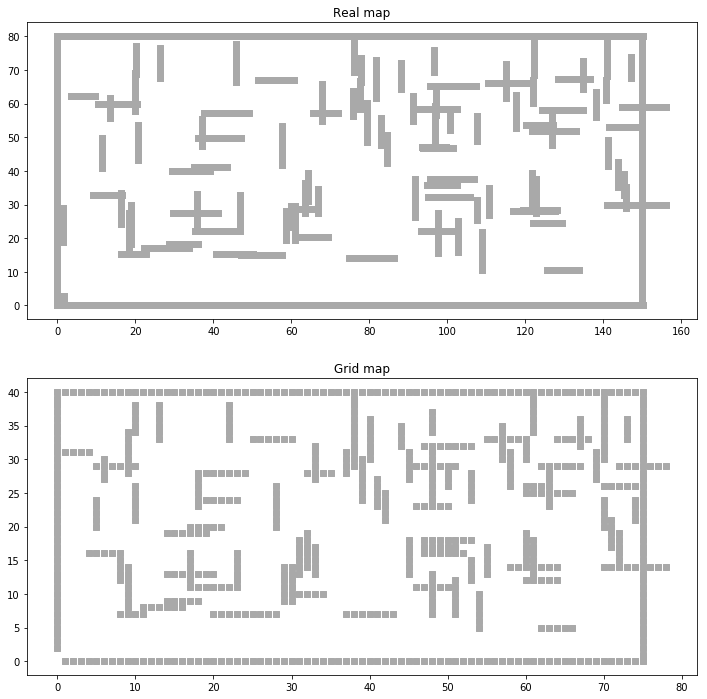

In [5]:
# Difference between real map and grid map
gp1 = GridProblem(grid_size=2, obstacles=random_lines())

plt.figure(figsize=(12, 12))
plt.subplot(211)
plt.title('Real map')
obs_list = transpose(list(gp1.obstacles))
plt.scatter(obs_list[0], obs_list[1], marker='s', color='darkgrey')

plt.subplot(212)
plt.title('Grid map')
grid_list = transpose(list(gp1.gridmap))
plt.scatter(grid_list[0], grid_list[1], marker='s', color='darkgrey')
plt.show()

<font color="red">
    
## 1-5. Node storage and Search methods

</font>

This section declare classic search algorithms to solve the problem defined above. Noted that we made a change in the code. `reached` variable need to be changed to global varible for storing the process of searching.

In [6]:
FIFOQueue = deque

LIFOQueue = list

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x): 
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)
         
    def add(self, item):
        """Add item to the queuez."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]
    
    def top(self): return self.items[0][1]

    def __len__(self): return len(self.items)

In [7]:
def breadth_first_search(problem):
    "Search shallowest nodes in the search tree first."
    frontier = FIFOQueue([Node(problem.initial)])
    global reached # <<<<<<<<<<< Only change here
    reached = set()
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached:
                reached.add(s)
                frontier.appendleft(child)
    return failure

### Best-first search

Best-first search with various f(n) functions gives us different search algorithms. Note that A* can be given a heuristic function h, providing additional information for finding an approximate solution. but if h is not supplied they use the problem's default h function.

**THE MAIN MISSION TODAY**  is to difine a custom search algrithm to solve grid problem. You can actually expect the path result according to what information you provided. For example, `uniform_cost_search` cares more about `path_cost` that means you may pay lower cost (designed by yourself) from A point to B point.

In [8]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first; make `reached` global."
    global reached # <<<<<<<<<<< Only change here
    frontier = PriorityQueue([Node(problem.initial)], key=f)
    reached = {}
    while len(frontier) != 0:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if (s not in reached) or (child.path_cost < reached[s].path_cost):
                reached[s] = child
                frontier.add(child)
    return failure

# It is also famous as Dijkstra's algorithm
def uniform_cost_search(problem):
    "Search nodes with minimum path cost first."
    return best_first_search(problem, f=lambda node: node.path_cost)

def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda node: node.path_cost + h(node))

def custom_search(problem):
    global gp_global
    
    if problem != None: gp_global = problem
        
    """Search nodes with minimum f(node), you need to define a f(n) by some attributes from node"""
    return best_first_search(problem, f=custom_func)

def custom_func(node):
    global gp_global
    '''
    You can return any infomation you want to provide
    
    Hint:
    if you want to get heuristic value on specific node --> gp_global.h(node)
    if you want to get action_list on specific state    --> gp_global.actions(node.state)
    if you want to get previous state (need NoneValue check) --> node.parent.state
    if you want to get current x,y --> (x,y) = node.state
    if you want to current direction and previous direction 
        
    -->if node.parent != None and node.parent.parent != None:
        dir1 = tuple(np.subtract(node.parent.state, node.state))
        dir2 = tuple(np.subtract(node.parent.parent.state, node.parent.state))
        print(dir1, dir2)
    
    '''

    return node.path_cost  

## 1-6. Ploting function

Here we declare a ploting function to visialize problem and test some search algorithm. you can see difference of them.

In [9]:
def plot_grid_problem(grid_problem, solution, reached=(), title='Search'):
    "Use matplotlib to plot the grid, obstacles, solution, and reached."
    plt.figure(figsize=(15, 6))
    plt.axis('off'); plt.axis('equal')
    
    # plot initial position and goal
    start = grid_problem.to_grid(grid_problem.initial)
    goal = grid_problem.to_grid(grid_problem.goal)
    plt.scatter(start[0], start[1], 11**2, marker='D', c='green')
    plt.scatter(goal[0], goal[1], 10**2, marker='D', c='red')
    plt.legend(['current_loc', 'goal_loc'])
    
    # plot obstacle
    obs_list = transpose(list(grid_problem.gridmap))
    if len(obs_list) != 0:
        plt.scatter(obs_list[0], obs_list[1], marker='s', color='darkgrey')
    
    # plot reached path
    reached_list = transpose([grid_problem.to_grid(point) for point in reached])
    if len(reached_list) != 0:
        plt.scatter(reached_list[0], reached_list[1], 1**2, marker='.', c='blue')
    
    # plot solution path
    traj_list = transpose([grid_problem.to_grid(point) for point in path_states(solution)])
    if len(traj_list) != 0:
        plt.scatter(traj_list[0], traj_list[1], marker='s', c='black')

    plt.show()
    print('{} {} search: {:.1f} path cost, {:,d} states reached'
          .format(' ' * 30, title, solution.path_cost, len(reached)))

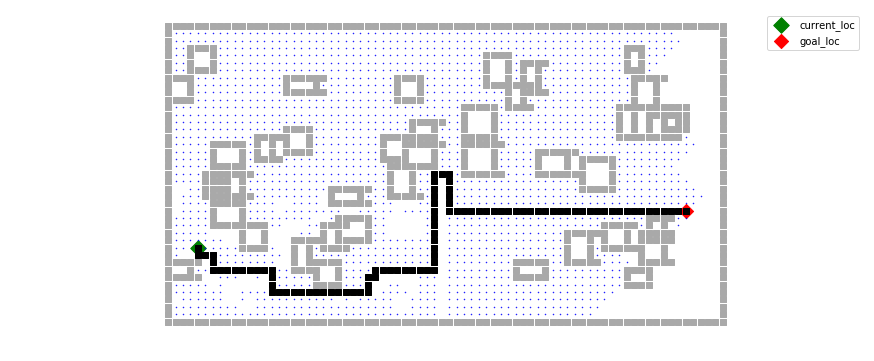

                               Breadth first search: 185.4 path cost, 1,850 states reached


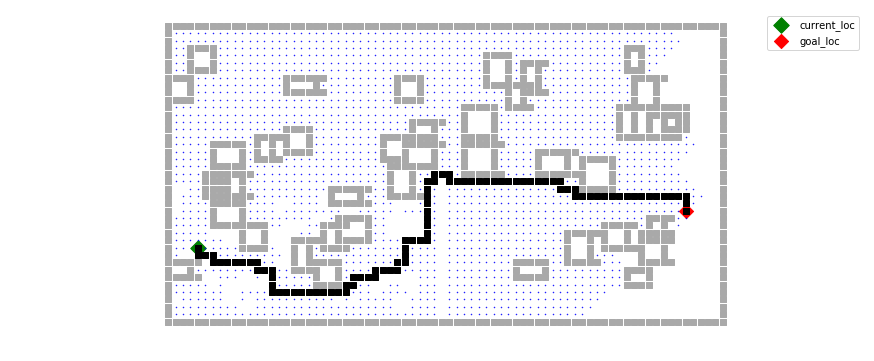

                               Dijkstra (Uniform cost) search: 185.4 path cost, 1,843 states reached


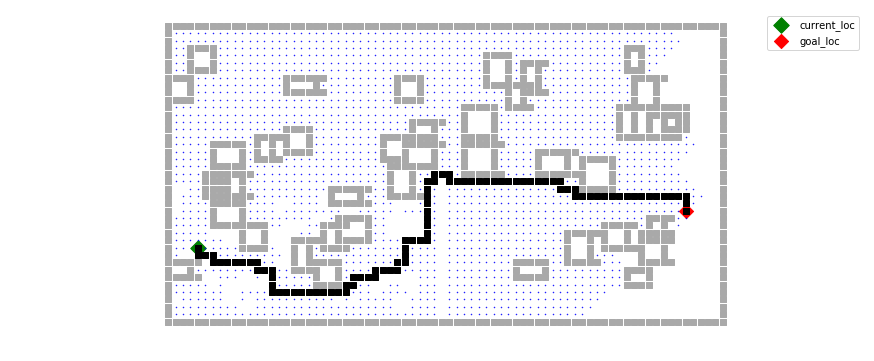

                               Custom algorithm search: 185.4 path cost, 1,843 states reached


In [12]:
# Test algorithms

gp1 = GridProblem(initial=(8, 20), goal=(140, 30), grid_size=2, obstacles=random_blocks())
sol1 = breadth_first_search(gp1)
plot_grid_problem(gp1, sol1, reached, title='Breadth first')

sol2 = uniform_cost_search(gp1)
plot_grid_problem(gp1, sol2, reached, title='Dijkstra (Uniform cost)')

sol3 = custom_search(gp1)
plot_grid_problem(gp1, sol3, reached, title='Custom algorithm')